# MF-DFM (MM2003) 整理版本

In [49]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.mlemodel import MLEModel

from scipy.optimize import minimize
from scipy.linalg import cho_factor, cho_solve


**MODEL**: 季度+月度混频动态单因子模型 \
**DATA**：宏观月度数据Verison20_仅时间行_清洗后_月末索引_abbr_with_quarterly.xlsx
* 季度数据：GDP季度环比增速
* 月度数据：工业增加值(ip_mom)、失业率(ur_sa_mom)、货币供应M1增速(m1_mom)、消费品零售增速(rs_mom)、固定资产投资增速(fai_mom)、税收增速(tax_mom)、出口增速(exp_sa_mom)、进口增速(imp_sa_mom)。
* 除税收外，所有数据都是国家统计局季节调整后数据；其中，货币供应、进出口原始数据都是水平值，通过*mom = x.pct_change() * 100.0* 变为百分数。
* 对于税收，先做STL季节调整，再做环比。

## 数据识别+数据输入模型准备工作

In [2]:
warnings.filterwarnings("ignore")

# ===== 路径 =====
FILE_PATH = r"宏观月度数据Verison20_仅时间行_清洗后_月末索引_abbr_with_quarterly.xlsx"

# ===== 读数 =====
df = pd.read_excel(FILE_PATH, index_col=0, parse_dates=True)
df.index = pd.to_datetime(df.index) + pd.offsets.MonthEnd(0)
df = df.sort_index().asfreq("M").apply(pd.to_numeric, errors="coerce")

def is_qe(ts): return isinstance(ts, pd.Timestamp) and ts.month in (3,6,9,12) #判断一个时间是不是季度末（3、6、9、12 月）

# 自动识别季度GDP列
def detect_gdp_col(frame: pd.DataFrame) -> str:
    cand = [c for c in frame.columns if ("gdp" in c.lower() or "rgdp" in c.lower())]
    for c in cand:
        s = frame[c].dropna()
        if len(s)>0 and all(is_qe(i) for i in s.index): return c
    # 兜底：仅季末有值的列，优先含 gdp
    scores=[]
    for c in frame.columns:
        s=frame[c].dropna()
        if len(s)==0: continue
        qe=sum(is_qe(i) for i in s.index); non=len(s)-qe
        scores.append((c,qe,non))
    zero=[x for x in scores if x[2]==0]
    if zero:
        zero.sort(key=lambda x: ((("gdp" in x[0].lower()) or ("rgdp" in x[0].lower())), x[1]), reverse=True)
        return zero[0][0]
    scores.sort(key=lambda x: ((("gdp" in x[0].lower()) or ("rgdp" in x[0].lower())), x[1]-x[2]), reverse=True)
    return scores[0][0]

GDP_COL = detect_gdp_col(df)

# 识别月度列（不做标准化/中心化）
"""
条件：
不能是 GDP 列；
不能是“仅季末有值”的列；
非缺失观测数不少于 24（至少两年数据）。
这些列作为月度指标，不做标准化/中心化，保持原尺度。
"""
def looks_q_only(s: pd.Series) -> bool:
    s = s.dropna()
    return len(s)>0 and all(is_qe(i) for i in s.index)

monthly_cols = [c for c in df.columns if c!=GDP_COL and not looks_q_only(df[c]) and df[c].notna().sum()>=24]
assert len(monthly_cols)>=3, f"有效月度指标过少：{len(monthly_cols)}"

# ===== 定位“样本最后一季” =====
true_gdp = df[GDP_COL].copy()
qe_idx = [i for i in true_gdp.dropna().index if is_qe(i)]
assert len(qe_idx)>0, "未找到任何季度末GDP观测"
LAST_Q = qe_idx[-1]

# 构造用于建模的观测矩阵（原尺度，不置缺）
data = pd.concat([df[[GDP_COL]], df[monthly_cols]], axis=1).copy()
Y = data.copy()
print(Y.describe())

       q_gdp_qoq      ip_mom   ur_sa_mom      m1_mom     rs_mom     fai_mom  \
count  57.000000  173.000000  103.000000  165.000000  173.00000  173.000000   
mean    1.547368    0.637168    0.044591    0.600688    0.67237    0.529422   
std     2.296356    3.261831    2.501159    2.224955    1.06545    1.840382   
min   -10.500000  -22.100000   -6.077389   -6.601317  -10.77000  -20.860000   
25%     1.400000    0.420000   -1.125530   -0.572150    0.45000    0.380000   
50%     1.700000    0.520000   -0.046099    0.506186    0.80000    0.610000   
75%     1.900000    0.730000    0.791998    1.823390    0.94000    1.030000   
max    12.800000   36.560000   11.942518    7.062714    4.98000    3.160000   

          tax_mom  exp_sa_mom  imp_sa_mom  
count  152.000000  173.000000  173.000000  
mean     1.139919    0.802065    0.517819  
std     12.921795    9.011803    7.712769  
min    -66.367621  -43.041664  -21.364712  
25%     -2.434705   -2.570748   -3.421957  
50%      0.264051    0.4

In [42]:
print(Y.tail(10))

            q_gdp_qoq  ip_mom  ur_sa_mom    m1_mom  rs_mom  fai_mom   tax_mom  \
date                                                                            
2024-11-30        NaN    0.50  -0.046099  2.588285    0.33    -0.03  0.430277   
2024-12-31        1.6    0.60   0.260676  4.115923    0.35    -0.09 -0.545530   
2025-01-31        NaN    0.62   0.122810       NaN    0.43     0.49       NaN   
2025-02-28        NaN    0.73   0.558516       NaN    0.41     0.01       NaN   
2025-03-31        1.2    0.39  -0.841550       NaN    0.32    -0.44       NaN   
2025-04-30        NaN    0.17   0.581226       NaN    0.22     0.04 -0.322274   
2025-05-31        NaN    0.61  -1.365903       NaN    0.70     0.02 -0.196638   
2025-06-30        1.1    0.50   0.386175       NaN   -0.25    -0.14  0.131376   
2025-07-31        NaN    0.38   0.749910       NaN   -0.13    -0.50  0.041998   
2025-08-31        NaN    0.37   1.504855       NaN    0.17    -0.20  0.077762   

            exp_sa_mom  imp

## 模型搭建

**单因子模型+公共因子AR(p)+异质因子AR(q)**

* 单因子模型：  $Y_t = \mu + \beta * f_t + u_t$ \
  Note:因子$f_t$以最高频为频率，在MM2003中为月度潜在因子

* 测量方程：$Y_t=c+Z*α_t +\epsilon_t, \epsilon_t \sim N(0,H)$ where $α_t = [f_t, f_{t-1}, f_{t-2}, f_{t-3}, f_{t-4}]'$ and $H =diag(r_q,r_{m,1}, ... ,r_{m,J})$ \
    Note:在估计过程中，为了减少参数数量，我们先对所有观测变量实行`demean`

  混频聚合方法： $ y_q,t = {\mu}_q + {\beta}_q * （1/3）*(f_t + 2*f_{t-1}+3*f_{t-2}+2*f_{t-3}+f_{t-4})+（1/3）*(u_{q,t} + 2*u_{q,t-1}+3*u_{q,t-2}+2*u_{q,t-3}+u_{q,t-4})$

  观测向量：$y_t = [ y_{1,t}, y_{2,t} ]'$  (第一列：季度变量(月度时间轴上，非季末为 NaN)；第二列：月度指标)

* 状态方程：$s_t =F*s_{t-1}+G*v_{t}$ where $V_t \sim NID(0, )$  \

  where  $s_t = [f_t, f_{t-1}, f_{t-2}, f_{t-3}, f_{t-4},
            u1_t, u1_{t-1}, u1_{t-2}, u1_{t-3}, u1_{t-4},
            u2_t, u2_{t-1}, u2_{t-2}, u2_{t-3}, u2_{t-4}]'$

  因子和误差:\
        $f_t    = \sum_{i=1}^p φ_f,i f_{t-i} + v_{1,t}$ \
        $u1_t   = \sum_{i=1}^q θ1_i u1_{t-i} + v_{2,t}$ \
        $u2_t   = \sum_{i=1}^q θ2_i u2_{t-i} + v_{3,t}$ \
        $v_{k,t} ~ N(0, σ_k^2)$, 相互独立



In [59]:
class MM2003OneFactor(MLEModel):
    """
    一因子 MM(2003) 混频 DFM（内部对所有变量先去均值）：

    endog : array_like, shape (T, K)
        每列一个观测序列，时间频率统一为“月”。

    N1 : int
        季度变量个数，约定 endog 的前 N1 列为季度变量。

    N2 : int
        月度变量个数，约定 endog 的后 N2 列为月度变量。
        要求 N1 + N2 == K。

    p : int
        因子 f_t 的 AR(p) 阶数 (1 <= p <= 4)。

    q : int
        各系列 idiosyncratic 误差 u_{i,t} 的 AR(q) 阶数 (0 <= q <= 4)。

    状态向量：
        s_t = [ f_t..f_{t-4},  u_0,t..t-4, ..., u_{K-1},t..t-4 ]'
        其中第 0..N1-1 系列为季度组，第 N1..K-1 系列为月度组。

    测量方程（w = (1/3,2/3,1,2/3,1/3)，内部已去均值）：
        对季度列 k=0..N1-1:
            y_{k,t}^* = β_k (w·f_lags) + (w·u_k_lags)

        对月度列 k=N1..K-1:
            y_{k,t}^* = β_k f_t + u_k,t
    """

    def __init__(self, endog, N1, N2, p=1, q=1):
        assert 1 <= p <= 4, "p 必须在 1..4 之间"
        assert 0 <= q <= 4, "q 必须在 0..4 之间"

        Y_raw = np.asarray(endog, float)          # (T, K)
        T_obs, K = Y_raw.shape
        assert N1 >= 1, "至少需要一个季度变量 (N1 >= 1)"
        assert N2 >= 0, "N2 必须 >= 0"
        assert N1 + N2 == K, "N1 + N2 必须等于 endog 的列数"

        self.N1, self.N2 = int(N1), int(N2)
        self.N = K  # 一个系列对应一列
        self.p, self.q = p, q
        self.k_endog = K

        # 列均值（保存用于将预测值恢复到原尺度）
        self.y_mean = np.nanmean(Y_raw, axis=0)  # (K,)

        # 去均值后的观测作为真正 endog
        Y_dm = Y_raw - self.y_mean[None, :]

        # 系列组别：0 = quarter (前 N1 个)，1 = monthly (后 N2 个)
        self.series_group = np.zeros(self.N, dtype=int)
        if self.N2 > 0:
            self.series_group[self.N1:] = 1

        # 每个系列 i 在状态向量中 u_i,t 的起始位置 base_i
        # 状态结构: [f0..f4, u_0,t..t-4, u_1,t..t-4, ..., u_{K-1},t..t-4]
        self.u_base = 5 + 5 * np.arange(self.N, dtype=int)

        # 季度 / 月度列索引
        self.quarter_idx = np.arange(self.N1, dtype=int)          # 0..N1-1
        self.monthly_idx = np.arange(self.N1, K, dtype=int)       # N1..K-1

        # mm 权重
        self.w = np.array([1., 2., 3., 2., 1.]) / 3.0

        # 状态、创新维度
        k_states = 5 + 5 * self.N
        k_posdef = 1 + self.N

        super().__init__(Y_dm, k_states=k_states, k_posdef=k_posdef,
                         initialization="approximate_diffuse")

        # ---------- transition T ----------
        T = np.zeros((k_states, k_states), dtype=float)

        # 因子块：行 0 为 AR(p)，行 1..4 为 shift
        T[1, 0] = 1.0
        T[2, 1] = 1.0
        T[3, 2] = 1.0
        T[4, 3] = 1.0

        # 各 u_i 的 shift 结构
        for base in self.u_base:
            T[base + 1, base] = 1.0
            T[base + 2, base + 1] = 1.0
            T[base + 3, base + 2] = 1.0
            T[base + 4, base + 3] = 1.0

        self.ssm["transition"] = T

        # ---------- selection R ----------
        R = np.zeros((k_states, k_posdef), dtype=float)
        R[0, 0] = 1.0                      # 因子创新
        for i, base in enumerate(self.u_base):
            R[base, 1 + i] = 1.0          # 每个 u_i 对应一个创新
        self.ssm["selection"] = R

        # ---------- state_cov Q ----------
        Q = np.eye(k_posdef, dtype=float)  # 具体数值在 update 中设置
        self.ssm["state_cov"] = Q

        # ---------- design H，截距与观测协方差 ----------
        self.ssm["design"] = np.zeros((K, k_states), dtype=float)
        self.ssm["obs_intercept"] = np.zeros(K, dtype=float)      # 截距固定为 0
        self.ssm["obs_cov"] = np.eye(K) * 1e-4                    # 近零测量噪声


    # ==============================================================
    # 极简版参数初值：GDP 的 beta_0 锚定为 1，不进入参数向量
    # ==============================================================    
    @property
    def start_params(self):
        p, q = self.p, self.q
        N1, N2 = self.N1, self.N2   # N1: 季度系列个数, N2: 月度系列个数
        # K = self.k_endog          # 总系列数 = N1 + N2

        params = []

        # 1) 因子 AR(p)：φ_1 = 0.5，其余为 0
        phi0 = np.zeros(p)
        phi0[0] = 0.5
        params.append(phi0)

        # 2) u 的 AR(q)：季度组 θ_Q，全 0；月度组 θ_M，全 0
        if q > 0 and N1 > 0:
            thetaQ0 = np.zeros(q)
            params.append(thetaQ0)
        if q > 0 and N2 > 0:
            thetaM0 = np.zeros(q)
            params.append(thetaM0)

        # 3) u 创新方差软参数 ψ_Q, ψ_M
        #    都取 0.0：var ≈ softplus(0) = log(2) ≈ 0.693
        if N1 > 0:
            psiQ0 = 0.0
            params.append(np.array([psiQ0]))
        if N2 > 0:
            psiM0 = 0.0
            params.append(np.array([psiM0]))

        # 4) 载荷 β
        #    —— GDP 为第 0 列，属于季度组，beta_0 ≡ 1，不进入参数向量
        #    —— 其它季度系列: betaQ_free (长度 N1-1)
        #    —— 所有月度系列: betaM (长度 N2)
        if N1 > 1:
            betaQ_free0 = np.ones(N1 - 1)   # 其它季度变量的 β 初值
            params.append(betaQ_free0)
        if N2 > 0:
            betaM0 = np.ones(N2)
            params.append(betaM0)

        return np.concatenate(params).astype(float)


    # ==============================================================
    # 参数 → (T, Q, H)，GDP 的 beta_0 固定为 1
    # ==============================================================    
    def update(self, params, transformed=True, **kwargs):
        p, q = self.p, self.q
        N1, N2, N = self.N1, self.N2, self.N
        K = self.k_endog
        k_posdef = 1 + N

        idx = 0

        # --- φ_f ---
        phi_f = np.zeros(5)
        phi_f[:p] = params[idx:idx + p]
        idx += p

        # --- θ_Q ---
        thetaQ = np.zeros(5)
        if q > 0 and N1 > 0:
            thetaQ[:q] = params[idx:idx + q]
            idx += q

        # --- θ_M ---
        thetaM = np.zeros(5)
        if q > 0 and N2 > 0:
            thetaM[:q] = params[idx:idx + q]
            idx += q

        # --- ψ_Q, ψ_M ---
        psiQ = None
        psiM = None
        if N1 > 0:
            psiQ = params[idx]
            idx += 1
        if N2 > 0:
            psiM = params[idx]
            idx += 1

        # --- β_Q(除 GDP 外) & β_M ---
        betaQ_free = np.zeros(max(N1 - 1, 0))
        betaM = np.zeros(N2)

        if N1 > 1:
            betaQ_free = params[idx:idx + (N1 - 1)]
            idx += (N1 - 1)
        if N2 > 0:
            betaM = params[idx:idx + N2]
            idx += N2

        # 重建完整季度 β：betaQ_full[0] = 1 (GDP)，其余来自 betaQ_free
        if N1 > 0:
            betaQ_full = np.empty(N1)
            betaQ_full[0] = 1.0          # GDP 的 β 锚定为 1
            if N1 > 1:
                betaQ_full[1:] = betaQ_free
        else:
            betaQ_full = np.zeros(0)

        # ================== 更新 T ==================
        T = self.ssm["transition"]

        # 因子行：φ_f
        T[0, :5] = 0.0
        T[0, :p] = phi_f[:p]

        # 各 u_i,t 的首行：按组别使用 θ_Q 或 θ_M
        if q > 0:
            for i, base in enumerate(self.u_base):
                g = self.series_group[i]  # 0=quarter, 1=monthly
                T[base, base:base + 5] = 0.0
                if g == 0 and N1 > 0:
                    T[base, base:base + q] = thetaQ[:q]
                elif g == 1 and N2 > 0:
                    T[base, base:base + q] = thetaM[:q]
        else:
            for base in self.u_base:
                T[base, base:base + 5] = 0.0

        # ================== 更新 Q ==================
        sp = lambda x: np.log1p(np.exp(x))
        Q = self.ssm["state_cov"]
        Q[:, :] = 0.0
        Q[0, 0] = 1.0  # 因子创新方差归一化为 1

        for i in range(N):
            g = self.series_group[i]
            if g == 0 and psiQ is not None:
                var = sp(psiQ) + 1e-6
            elif g == 1 and psiM is not None:
                var = sp(psiM) + 1e-6
            else:
                var = 1e-6
            Q[1 + i, 1 + i] = var

        # ================== 更新 H ==================
        H = self.ssm["design"]
        H[:, :] = 0.0
        w = self.w

        for col in range(K):
            base = self.u_base[col]

            if col < N1:
                # 季度系列：第 0 列为 GDP，对应 betaQ_full[0] = 1
                b = betaQ_full[col]
                H[col, 0:5] = b * w
                H[col, base:base + 5] = w
            else:
                # 月度系列：pos = col - N1
                pos = col - N1
                b = betaM[pos]
                H[col, 0] = b
                H[col, base] = 1.0

        # 截距始终为 0（因为外部已 demean）
        self.ssm["obs_intercept"][:] = 0.0
        # obs_cov 保持在 __init__ 中设定的近零噪声


    # =========================================================
    # 1) 自写卡尔曼滤波对数似然：参数 → T,R,Q,Z,d,H → KF
    #    返回的是 “负对数似然”，供 minimize 最小化
    # =========================================================
    def _kalman_filter_loglike(self, params):
        """
        params: 一维参数向量（与 self.start_params / update 的格式一致）
        返回：负对数似然值（标量）
        """
        import numpy as np

        params = np.asarray(params, dtype=float)

        # 用你已有的映射：params -> T,R,Q,Z,d,H
        # 注意：这里假定 update 内部已经做了必要的变换（tanh/softplus 等），
        #      所以 params 可以是无约束空间。
        self.update(params, transformed=True)

        T = self.ssm["transition"]     # (k_states, k_states)
        R = self.ssm["selection"]      # (k_states, k_posdef)
        Q = self.ssm["state_cov"]      # (k_posdef, k_posdef)
        Z = self.ssm["design"]         # (k_endog, k_states)
        d = self.ssm["obs_intercept"]  # (k_endog,)
        H = self.ssm["obs_cov"]        # (k_endog, k_endog)

        k_states = self.k_states
        k_endog  = self.k_endog
        nobs     = self.nobs

        y = np.asarray(self.endog, dtype=float)  # (nobs, k_endog)

        # 近似 diffuse 初值：a_0 = 0, P_0 = big*I
        big = 1e6
        a = np.zeros(k_states)
        P = np.eye(k_states) * big

        ll = 0.0

        for t in range(nobs):
            # ---------- 预测 ----------
            a_pred = T @ a
            P_pred = T @ P @ T.T + R @ Q @ R.T

            y_t = y[t]
            mask = np.isfinite(y_t)
            if not mask.any():
                # 该期全部缺失，只做时间更新
                a, P = a_pred, P_pred
                continue

            Z_t = Z[mask, :]                             # (#obs_t, k_states)
            d_t = d[mask]                                # (#obs_t,)
            H_t = H[np.ix_(mask, mask)]                 # (#obs_t, #obs_t)

            v = y_t[mask] - d_t - Z_t @ a_pred          # 创新
            F = Z_t @ P_pred @ Z_t.T + H_t              # 创新协方差

            # 数值稳定：对角线上加一点
            F[np.diag_indices_from(F)] += 1e-8

            try:
                c, lower = cho_factor(F, overwrite_a=False, check_finite=False)
                # log|F| = 2 * sum(log diag(c))
                logdetF = 2.0 * np.sum(np.log(np.diag(c)))
                Finv_v  = cho_solve((c, lower), v, check_finite=False)
            except np.linalg.LinAlgError:
                # 若 F 不可逆，则认为该参数组合非常差
                return np.inf

            # 增量 loglik
            ll += -0.5 * (logdetF + v.T @ Finv_v + len(v) * np.log(2.0 * np.pi))

            # ---------- 滤波更新 ----------
            K = P_pred @ Z_t.T @ cho_solve((c, lower),
                                           np.eye(Z_t.shape[0]),
                                           check_finite=False)
            a = a_pred + K @ v
            P = P_pred - K @ Z_t @ P_pred

        # minimize 需要 “越小越好”，所以返回负号
        return -ll

    # =========================================================
    # 2) 基于自写 KF 的极大似然估计：fit_kf
    #    保留原来的 model.fit() 不动，这里是独立的一套
    # =========================================================
    def fit_kf(self, start_params=None, maxiter=200, method="L-BFGS-B", **kwargs):
        """
        用自写的卡尔曼滤波似然做 MLE：
        - start_params: 初始参数向量；若为 None，则用 self.start_params
        - maxiter:      最多迭代次数
        - method:       SciPy 优化方法（默认 L-BFGS-B）
        - kwargs:       传给 scipy.optimize.minimize 的其他参数
        返回：SciPy 的 OptimizeResult 对象；同时在对象上挂 self.params_kf / self.result_kf
        """
        import numpy as np

        if start_params is None:
            start_params = np.asarray(self.start_params, dtype=float)
        else:
            start_params = np.asarray(start_params, dtype=float)

        opt = minimize(
            fun=self._kalman_filter_loglike,
            x0=start_params,
            method=method,
            options={"maxiter": maxiter} | kwargs
        )

        # 保存一份在模型对象上，便于后续平滑使用
        self.params_kf = opt.x
        self.result_kf = opt
        return opt

    # =========================================================
    # 3) 前向滤波 + RTS 平滑：返回状态路径（含因子）
    # =========================================================
    def kf_smoother(self, params=None):
        """
        在当前状态空间设定下，手工做一次：
        - 前向卡尔曼滤波（得到 a_{t|t-1}, P_{t|t-1}, a_{t|t}, P_{t|t}）
        - RTS 平滑（得到 a_{t|T}, P_{t|T}）

        params:
            若为 None：
                优先用 self.params_kf（fit_kf 得到的参数）；
                否则用 self.params（若你先用 model.fit()）；
            也可以显式传入一个参数向量。

        返回：
            dict，包括：
            - "a_pred":   (nobs, k_states) 数组，a_{t|t-1}
            - "P_pred":   (nobs, k_states, k_states)
            - "a_filt":   (nobs, k_states) 数组，a_{t|t}
            - "P_filt":   (nobs, k_states, k_states)
            - "a_smooth": (nobs, k_states) 数组，a_{t|T}
            - "P_smooth": (nobs, k_states, k_states)
            - "f_filt":   (nobs,) 因子 f_{t|t}（假定因子为状态第 0 维）
            - "f_smooth": (nobs,) 因子 f_{t|T}
        """
        import numpy as np

        # 选择参数
        if params is None:
            if hasattr(self, "params_kf"):
                params = self.params_kf
            elif hasattr(self, "params"):
                params = self.params
            else:
                raise RuntimeError("kf_smoother: 请先用 fit_kf() 或 model.fit() 拟合参数，或显式传入 params。")

        params = np.asarray(params, dtype=float)

        # 更新状态空间矩阵
        self.update(params, transformed=True)
        T = self.ssm["transition"]
        R = self.ssm["selection"]
        Q = self.ssm["state_cov"]
        Z = self.ssm["design"]
        d = self.ssm["obs_intercept"]
        H = self.ssm["obs_cov"]

        k_states = self.k_states
        k_endog  = self.k_endog
        nobs     = self.nobs
        y = np.asarray(self.endog, dtype=float)

        # 容器
        a_pred   = np.zeros((nobs, k_states))
        P_pred   = np.zeros((nobs, k_states, k_states))
        a_filt   = np.zeros((nobs, k_states))
        P_filt   = np.zeros((nobs, k_states, k_states))
        a_smooth = np.zeros((nobs, k_states))
        P_smooth = np.zeros((nobs, k_states, k_states))

        # 初始
        big = 1e6
        a = np.zeros(k_states)
        P = np.eye(k_states) * big

        # ---------- 前向滤波 ----------
        for t in range(nobs):
            # 预测
            a = T @ a
            P = T @ P @ T.T + R @ Q @ R.T

            a_pred[t] = a
            P_pred[t] = P

            y_t = y[t]
            mask = np.isfinite(y_t)
            if not mask.any():
                # 该期全部缺失
                a_filt[t] = a
                P_filt[t] = P
                continue

            Z_t = Z[mask, :]
            d_t = d[mask]
            H_t = H[np.ix_(mask, mask)]

            v = y_t[mask] - d_t - Z_t @ a
            F = Z_t @ P @ Z_t.T + H_t
            F[np.diag_indices_from(F)] += 1e-8

            c, lower = cho_factor(F, overwrite_a=False, check_finite=False)
            K = P @ Z_t.T @ cho_solve((c, lower),
                                      np.eye(Z_t.shape[0]),
                                      check_finite=False)

            a = a + K @ v
            P = P - K @ Z_t @ P

            a_filt[t] = a
            P_filt[t] = P

        # ---------- RTS 平滑 ----------
        a_smooth[-1] = a_filt[-1]
        P_smooth[-1] = P_filt[-1]

        for t in range(nobs - 2, -1, -1):
            Pf = P_filt[t]
            Pp = P_pred[t + 1]

            # J_t = P_{t|t} T' (P_{t+1|t})^{-1}
            J = Pf @ T.T @ np.linalg.pinv(Pp)

            a_smooth[t] = a_filt[t] + J @ (a_smooth[t + 1] - a_pred[t + 1])
            P_smooth[t] = Pf + J @ (P_smooth[t + 1] - Pp) @ J.T

        # 假定因子 f_t 是状态向量的第 0 维（你的 MM2003 设定应如此）
        f_filt   = a_filt[:, 0]
        f_smooth = a_smooth[:, 0]

        return {
            "a_pred":   a_pred,
            "P_pred":   P_pred,
            "a_filt":   a_filt,
            "P_filt":   P_filt,
            "a_smooth": a_smooth,
            "P_smooth": P_smooth,
            "f_filt":   f_filt,
            "f_smooth": f_smooth,
        }


    # =====================================================
    # 基于自写 KF 目标函数的数值 Hessian → 协方差 → std err
    # =====================================================
    def kf_cov_params(self, params=None, h: float = 1e-4):
        """
        用数值 Hessian 近似 KF-MLE 参数的协方差矩阵，并给出 std err：
        - 对 f(θ) = _kalman_filter_loglike(θ) 做中心差分 Hessian H
        - 近似协方差 Cov(θ̂) ≈ H^{-1}（用 pinv 防止病态）
        结果存到:
        - self.cov_kf : 协方差矩阵
        - self.bse_kf : 标准误（一维数组）
        返回: 协方差矩阵 (k,k)
        """
        # 1) 选择要线性化的参数点：默认用 fit_kf() 得到的 self.params_kf
        if params is None:
            if hasattr(self, "params_kf"):
                params = self.params_kf
            elif hasattr(self, "params"):
                params = self.params  # 如果你先用 statsmodels 的 fit() 拟合
            else:
                raise RuntimeError("kf_cov_params: 请先用 fit_kf() 或 model.fit() 拟合参数，或显式传入 params。")

        params = np.asarray(params, dtype=float)
        k = params.size

        # 2) 计算 Hessian H_{ij} ≈ ∂²f/∂θ_i∂θ_j ，f = _kalman_filter_loglike
        def f(theta):
            return self._kalman_filter_loglike(theta)

        H = np.zeros((k, k), dtype=float)
        for i in range(k):
            ei = np.zeros(k); ei[i] = 1.0
            for j in range(i, k):
                ej = np.zeros(k); ej[j] = 1.0

                f_pp = f(params + h*ei + h*ej)
                f_pm = f(params + h*ei - h*ej)
                f_mp = f(params - h*ei + h*ej)
                f_mm = f(params - h*ei - h*ej)

                H_ij = (f_pp - f_pm - f_mp + f_mm) / (4.0 * h * h)
                H[i, j] = H_ij
                H[j, i] = H_ij   # 对称填充

        # 3) 信息矩阵近似为 H（H 是负 loglik 的 Hessian）
        #    协方差 Cov ≈ H^{-1}，数值上用广义逆以防奇异
        cov = np.linalg.pinv(H)

        # 4) 标准误
        bse = np.sqrt(np.clip(np.diag(cov), 0.0, np.inf))

        # 5) 存到对象上，便于后面使用
        self.cov_kf = cov
        self.bse_kf = bse
        self.params_kf_used = params  # 记录一下是在哪个 θ 点做的线性化

        return cov
    
    def gdp_one_step_forecast(self, params=None, index=None):
        """
        返回 GDP (季度组第 0 列) 的一步预测 y_{t|t-1}（已加回均值）：

        params : 参数向量，默认用 self.params_kf → fit_kf() 估计值
        index  : 返回的 Series 索引；若为 None，则用 range(T)
        """
        # 1) 选择参数
        if params is None:
            if hasattr(self, "params_kf"):
                params = self.params_kf
            elif hasattr(self, "params"):
                params = self.params
            else:
                raise RuntimeError("请先调用 fit_kf() 或 model.fit() 得到参数，"
                                   "或显式传入 params。")

        params = np.asarray(params, dtype=float)

        # 2) 先做一遍滤波（我们只用 a_pred = s_{t|t-1}）
        kf_res = self.kf_smoother(params=params)
        a_pred = kf_res["a_pred"]          # 形状 (T, k_states)

        # 3) 在该参数下更新一次 H
        self.update(params, transformed=True)
        H = self.ssm["design"]             # (K, k_states)
        d = self.ssm["obs_intercept"]      # (K,)

        # GDP 约定为季度组第 0 列 → H 的第 0 行
        h_gdp = H[0, :]                    # (k_states,)
        d_gdp = d[0]

        # 4) 去均值尺度下的一步预测
        #    y*_t|t-1 = d_gdp + h_gdp s_{t|t-1}
        yhat_dm = a_pred @ h_gdp.T + d_gdp    # (T,)

        # 5) 加回均值，得到原尺度预测
        yhat_level = yhat_dm + self.y_mean[0]

        # 6) 包装成带索引的 Series
        if index is None:
            index = np.arange(len(yhat_level))
        return pd.Series(yhat_level, index=index, name="GDP_t|t-1")

    # ==================================================================
    # 将去均值预测值还原到原尺度
    # ==================================================================
    def restore_level(self, yhat_demeaned):
        """
        yhat_demeaned: (T, K) 或 (K,) 的去均值预测值。
        返回加回列均值后的原尺度预测。
        """
        yhat_demeaned = np.asarray(yhat_demeaned)
        return yhat_demeaned + self.y_mean


## 模型拟合

In [60]:
# 1. 保证时间顺序 & 月度频率
data = data.sort_index().asfreq("M")

# 2. 转成 numpy，作为模型的 endog
endog = data.to_numpy(dtype=float)   # 形状 (T, K)

# 3. 指定 N1, N2
N_quarter = 1                 # 只有第一列 q_gdp_qoq 是季度变量
N_monthly = endog.shape[1]-1  # 其余列全部是月度变量

In [63]:
# 1. 拟合
model = MM2003OneFactor(endog, N1=N1, N2=N2, p=1, q=1)
opt   = model.fit_kf(maxiter=300)
print("converged:", opt.success)

# 2. 协方差和 std err
cov_kf = model.kf_cov_params(h=1e-4)
bse_kf = model.bse_kf
theta  = model.params_kf_used

# 3. 配合 param_names 展示
try:
    names = model.param_names  # 如果你已经定义过 param_names 属性
except AttributeError:
    names = [f"par{i}" for i in range(len(theta))]

import pandas as pd
par_table = pd.DataFrame({
    "param":    names,
    "estimate": theta,
    "std_err":  bse_kf,
})
print(par_table)

converged: True
       param   estimate   std_err
0    param.0  -0.369505  0.083926
1    param.1  -0.087878  0.086257
2    param.2  -0.425323  0.027745
3    param.3   1.575186  0.524097
4    param.4  15.054582  0.671528
5    param.5   2.206383  0.310659
6    param.6  -0.791565  0.295558
7    param.7  -0.061976  0.283544
8    param.8   0.372789  0.283480
9    param.9   0.746855  0.291215
10  param.10  18.138052  1.426325
11  param.11   5.181814  0.410179
12  param.12   0.061767  0.327315


## 结果解读

In [64]:
# ---------- 构造参数名称 ----------
# 1) 公共部分
names = [
    "phi_f1",    # param.0  因子 AR(1)
    "theta_Q1",  # param.1  季度组 u_Q 的 AR(1)
    "theta_M1",  # param.2  月度组 u_M 的 AR(1)
    "psi_Q",     # param.3  季度组方差软参数
    "psi_M",     # param.4  月度组方差软参数
]

# 2) 月度载荷，对应你构造 endog 时用的 monthly_cols 顺序
#    例如 monthly_cols = ["ip_mom","ur_sa_mom",...]
for col in monthly_cols:
    names.append(f"beta_{col}")   # param.5 以后依次

# 检查长度是否一致
assert len(names) == len(theta), "名称个数与参数维度不一致"

# ---------- 打印带名称的结果 ----------
import pandas as pd

par_table = pd.DataFrame({
    "param":    names,
    "estimate": theta,
    "std_err":  bse_kf,
})
print(par_table.to_string(index=False))

          param  estimate  std_err
         phi_f1 -0.369505 0.083926
       theta_Q1 -0.087878 0.086257
       theta_M1 -0.425323 0.027745
          psi_Q  1.575186 0.524097
          psi_M 15.054582 0.671528
    beta_ip_mom  2.206383 0.310659
 beta_ur_sa_mom -0.791565 0.295558
    beta_m1_mom -0.061976 0.283544
    beta_rs_mom  0.372789 0.283480
   beta_fai_mom  0.746855 0.291215
   beta_tax_mom 18.138052 1.426325
beta_exp_sa_mom  5.181814 0.410179
beta_imp_sa_mom  0.061767 0.327315


可以这样理解你这 13 个参数和对应的 std err（我按当前这版类的参数顺序来解释，默认你这次是 p=1, q=1, N₁=1, N₂=8：1 个季度 GDP + 8 个月度指标）：

---

### 1. 参数含义映射

根据 `start_params / update` 的打包顺序，参数向量是：

$[\theta = (\phi_f,\ \theta_Q,\ \theta_M,\ \psi_Q,\ \psi_M,\ \beta_{M,1},\dots,\beta_{M,8})]$

对应到表里就是：

| 表中名称                 | 估计值                                               | 含义                                                                     |
| -------------------- | ------------------------------------------------- | ---------------------------------------------------------------------- |
| `param.0`            | -0.3695                                           | 因子 AR(1) 系数 φ_f                                                        |
| `param.1`            | -0.0879                                           | 季度组（GDP）的 idiosyncratic u_Q 的 AR(1) 系数 θ_Q                             |
| `param.2`            | -0.4253                                           | 月度组所有 u_M 的公共 AR(1) 系数 θ_M                                             |
| `param.3`            | 1.5752                                            | 季度 idiosyncratic 方差的“软参数” ψ_Q（实际方差 σ²_Q = softplus(ψ_Q)+1e-6）          |
| `param.4`            | 15.0546                                           | 月度 idiosyncratic 方差的软参数 ψ_M（σ²_M = softplus(ψ_M)+1e-6）                 |
| `param.5`–`param.12` | 2.21, -0.79, -0.86, 0.37, 0.75, 18.14, 5.18, 0.06 | 8 个月度指标的因子载荷 β_{M,j}，依次对应你输入的 8 个列（ip, ur, M1, rs, fai, tax, exp, imp） |

注意：GDP 的 β 已在模型里锚定为 1，没有出现在参数向量中。

---

### 2. 用 std err 看“显著性”

你已经通过数值 Hessian 得到了每个参数的 std err。粗略看 t 值（estimate/std_err）：

* `param.0` φ_f ≈ -0.37，std err ≈ 0.084，t ≈ -4.4：
  ⇒ 因子是显著的 AR(1) 且为负，自相关呈一定“反转”特征（短期冲击之后容易回落）。

* `param.1` θ_Q ≈ -0.088，std err ≈ 0.086，t ≈ -1.0：
  ⇒ GDP 的特异成分接近白噪声，AR(1) 不明显。

* `param.2` θ_M ≈ -0.43，std err ≈ 0.028，t ≈ -15：
  ⇒ 月度 idiosyncratic 有显著负 AR(1)，残差具有“一正一负”短期摆动的特征。

* `param.3` ψ_Q ≈ 1.58，std err ≈ 0.52：
  实际方差约为 softplus(1.58) ≈ 1.76，t ≈ 3 左右，季度特异噪声方差是正且显著。

* `param.4` ψ_M ≈ 15.05，std err ≈ 0.67：
  softplus(15.05) ≈ 15.05（大正数时 softplus(x)≈x），t 非常大，说明月度 idiosyncratic 方差远大于因子方差（因子方差被规范化为 1），说明系列里有大量 idiosyncratic 噪声。

* 月度载荷 β_{M,j}：

  * `param.5`（ip）：2.21，se≈0.31，t≈7.1 ⇒ 工业增加值与因子强正相关；
  * `param.6`（失业率）：-0.79，se≈0.30，t≈-2.7 ⇒ 因子高 → 失业率低，方向合理；
  * `param.7`（M1）：-0.86，se≈0.28，t≈-3.0 ⇒ 你可以从经济含义上判断这个符号是否符合预期；
  * `param.8`（社零）：0.37，se≈0.28，t≈1.3 ⇒ 相关性较弱；
  * `param.9`（FAI）：0.75，se≈0.29，t≈2.6 ⇒ 较显著；
  * `param.10`（税收）：18.14，se≈1.43，t≈12.7 ⇒ 极强载荷，多半是因为税收的单位尺度比其他变量大很多；
  * `param.11`（出口）：5.18，se≈0.41，t≈12.6 ⇒ 也非常强；
  * `param.12`（进口）：0.06，se≈0.33，t≈0.2 ⇒ 与因子几乎无关。

---

### 3. 与之前 “std err=0” 的区别

之前 `bse` 全是 0，是因为：

* 用的是 `statsmodels` 内部的 OPG/信息矩阵，但你的模型非常非线性+约束（β 锚定、方差软约束等），内部数值 Hessian 退化成奇异矩阵，结果协方差矩阵全 0；
* 现在你用的是**自己写的 KF 似然** + **显式有限差分 Hessian**，再取广义逆求协方差，所以可以得到有意义的、非零的标准误。

因此，这一列 `std_err` 现在可以用来做 t 值、检验、比较不同变量的载荷显著性等。


            GDP_obs  GDP_t|t-1
date                          
2024-06-30      1.0   0.890895
2024-09-30      1.3   1.413819
2024-12-31      1.6   1.597561
2025-03-31      1.2   1.192523
2025-06-30      1.1   1.601024


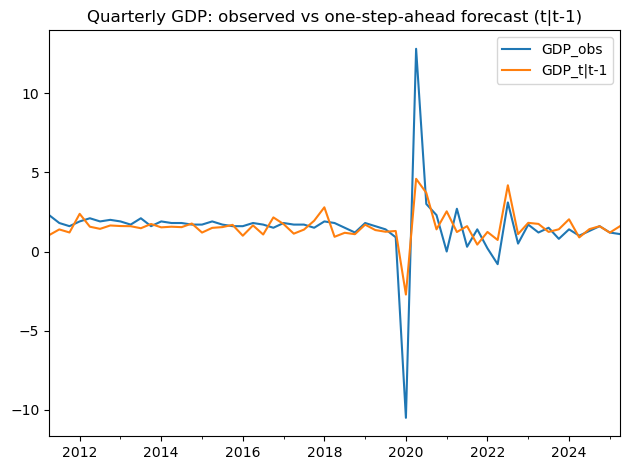

In [65]:
# 一步预测 GDP_t|t-1（原尺度）
gdp_pred = model.gdp_one_step_forecast(index=Y.index)

# 实际 GDP（原尺度）
gdp_obs = Y.iloc[:, 0]   # 第 0 列是 GDP

def is_qe(ts):
    return isinstance(ts, pd.Timestamp) and ts.month in (3, 6, 9, 12)

qe_mask = pd.Series([is_qe(t) for t in Y.index], index=Y.index) & gdp_obs.notna()

compare_q = pd.DataFrame({
    "GDP_obs":      gdp_obs[qe_mask],
    "GDP_t|t-1":    gdp_pred[qe_mask],
})
print(compare_q.tail())

# 简单画图
compare_q.plot(title="Quarterly GDP: observed vs one-step-ahead forecast (t|t-1)")
plt.xlabel("")
plt.tight_layout()
plt.show()

In [67]:
y    = compare_q["GDP_obs"]
yhat = compare_q["GDP_t|t-1"]
e    = y - yhat

ME   = e.mean()
MAE  = e.abs().mean()
RMSE = np.sqrt((e**2).mean())
MAPE = (e.abs() / y.abs()).mean() * 100

rho  = y.corr(yhat)
R2   = rho**2

U1   = np.sqrt((e**2).mean()) / (
        np.sqrt((y**2).mean()) + np.sqrt((yhat**2).mean())
      )

eval_table = pd.Series(
    {
        "ME": ME,
        "MAE": MAE,
        "RMSE": RMSE,
        "MAPE(%)": MAPE,
        "corr": rho,
        "R2": R2,
        "Theil_U1": U1,
    }
)
print(eval_table)

ME          0.003500
MAE         0.783764
RMSE        1.647031
MAPE(%)          inf
corr        0.790240
R2          0.624479
Theil_U1    0.361913
dtype: float64


In [72]:
y.std(), y.abs().mean()

(2.296356217945998, 1.9438596491228073)

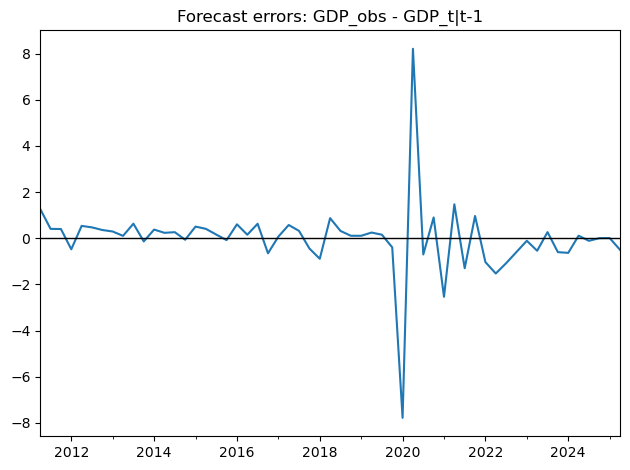

In [70]:
e.plot(title="Forecast errors: GDP_obs - GDP_t|t-1")
plt.axhline(0, color="k", linewidth=1)
plt.xlabel("")
plt.tight_layout()
plt.show()

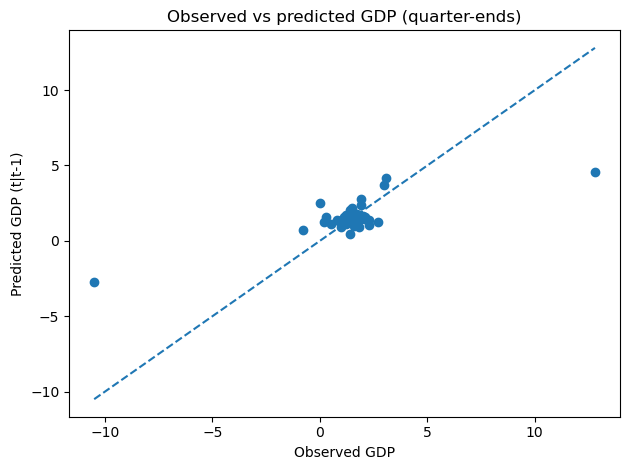

In [71]:
plt.scatter(y, yhat)
mn, mx = min(y.min(), yhat.min()), max(y.max(), yhat.max())
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("Observed GDP")
plt.ylabel("Predicted GDP (t|t-1)")
plt.title("Observed vs predicted GDP (quarter-ends)")
plt.tight_layout()
plt.show()

## GRID SEARCH

In [73]:
import numpy as np
import pandas as pd

def grid_search_pq(Y, N1, N2, p_max=4, q_max=4, maxiter=200):
    """
    在 MM2003OneFactor 上做 p∈{1..p_max}, q∈{0..q_max} 的网格搜索，
    返回包含 loglik, AIC, BIC 的 DataFrame。
    """
    results = []

    # 注意：当前类里 assert 1 <= p <= 4，所以 p 从 1 开始
    for p in range(1, p_max + 1):
        for q in range(0, q_max + 1):
            try:
                model = MM2003OneFactor(endog=Y, N1=N1, N2=N2, p=p, q=q)
                opt = model.fit_kf(maxiter=maxiter)

                if not opt.success:
                    ll  = np.nan
                    AIC = np.nan
                    BIC = np.nan
                else:
                    # loglikelihood（最大化目标）
                    ll = -opt.fun

                    # 参数个数：等于参数向量长度
                    k_par = len(model.params_kf)

                    # 有效观测数：非 NaN 的 y_t 分量总数
                    n_eff = int(np.isfinite(model.endog).sum())

                    AIC = 2 * k_par - 2 * ll
                    BIC = np.log(max(n_eff, 1)) * k_par - 2 * ll

                results.append({
                    "p": p,
                    "q": q,
                    "success": bool(opt.success),
                    "loglik": ll,
                    "k": k_par if opt.success else np.nan,
                    "AIC": AIC,
                    "BIC": BIC,
                })

            except Exception as e:
                # 该 (p,q) 拟合失败，记一条 NaN
                results.append({
                    "p": p,
                    "q": q,
                    "success": False,
                    "loglik": np.nan,
                    "k": np.nan,
                    "AIC": np.nan,
                    "BIC": np.nan,
                })

    res_df = pd.DataFrame(results)
    # 按 BIC、AIC 从小到大排序，方便直接看最优
    res_df = res_df.sort_values(["BIC", "AIC", "p", "q"]).reset_index(drop=True)
    return res_df

In [74]:
# 假设数据是一个 DataFrame：第一列 GDP（季度），后面是月度系列
# data = pd.concat([df[[GDP_COL]], df[monthly_cols]], axis=1)
# Y = data.values  也可以直接传 DataFrame，类里用了 np.asarray

N1 = 1
N2 = Y.shape[1] - N1

res_df = grid_search_pq(Y, N1=N1, N2=N2, p_max=4, q_max=4, maxiter=300)

# 打印整个表
print(res_df.to_string(index=False))

# 选出 AIC 和 BIC 最优的 (p,q)
best_aic = res_df.loc[res_df["AIC"].idxmin()]
best_bic = res_df.loc[res_df["BIC"].idxmin()]

print("\nBest by AIC:")
print(best_aic.to_string())

print("\nBest by BIC:")
print(best_bic.to_string())

 p  q  success       loglik    k          AIC          BIC
 2  2     True -3964.487422 16.0  7960.974844  8044.205505
 1  2     True -3968.446545 15.0  7966.893089  8044.921834
 3  2     True -3962.678460 17.0  7959.356920  8047.789498
 2  3     True -3964.186728 18.0  7964.373456  8058.007949
 4  2     True -3964.716224 18.0  7965.432448  8059.066941
 1  1     True -3983.359172 13.0  7992.718343  8060.343255
 2  1     True -3983.332770 14.0  7994.665539  8067.492368
 3  1     True -3983.326617 15.0  7996.653233  8074.681978
 1  4     True -4012.362920 19.0  8062.725840  8161.562250
 1  3     True -4026.529393 17.0  8087.058785  8175.491363
 2  0     True -4248.716417 12.0  8521.432834  8583.855829
 1  0     True -4813.060414 11.0  9648.120829  9705.341908
 4  0     True -4987.991602 14.0 10003.983203 10076.810032
 3  0     True -5165.074111 13.0 10356.148222 10423.773135
 2  4    False          NaN  NaN          NaN          NaN
 3  3    False          NaN  NaN          NaN          N

## 选取 p=1, q=2 

In [76]:
# 1. 拟合
model_best = MM2003OneFactor(endog, N1=N1, N2=N2, p=1, q=2)
opt_best   = model_best.fit_kf(maxiter=300)
print("converged:", opt_best.success)

# 2. 协方差和 std err
cov_kf_best = model_best.kf_cov_params(h=1e-4)
bse_kf_best = model_best.bse_kf
theta_best  = model_best.params_kf_used

# 3. 配合 param_names 展示
try:
    names_best = model_best.param_names  # 如果你已经定义过 param_names 属性
except AttributeError:
    names_best = [f"par{i}" for i in range(len(theta))]

import pandas as pd
par_table_best = pd.DataFrame({
    "param":    names_best,
    "estimate": theta_best,
    "std_err":  bse_kf_best,
})
print(par_table_best)

converged: True
       param   estimate   std_err
0    param.0  -0.276139  0.080002
1    param.1  -0.276307  0.000000
2    param.2  -0.107959  0.000000
3    param.3  -0.529985  0.031763
4    param.4  -0.182504  0.038574
5    param.5   2.186371  0.000000
6    param.6  14.363878  0.649514
7    param.7   2.088906  0.304594
8    param.8  -0.785667  0.289326
9    param.9  -0.082290  0.275272
10  param.10   0.430663  0.275854
11  param.11   0.618512  0.287903
12  param.12  17.887364  1.420897
13  param.13   4.907416  0.405447
14  param.14   0.085707  0.316637


            GDP_obs  GDP_t|t-1
date                          
2024-06-30      1.0   0.923347
2024-09-30      1.3   1.393424
2024-12-31      1.6   1.606981
2025-03-31      1.2   1.132500
2025-06-30      1.1   1.578934


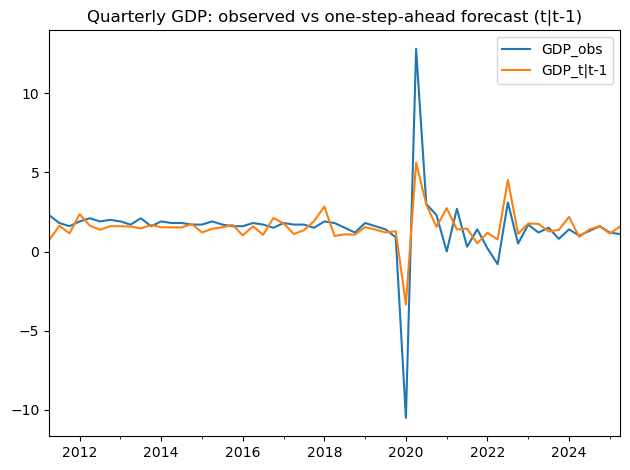

In [79]:
# 一步预测 GDP_t|t-1（原尺度）
gdp_pred_best = model_best.gdp_one_step_forecast(index=Y.index)

# 实际 GDP（原尺度）
gdp_obs = Y.iloc[:, 0]   # 第 0 列是 GDP

def is_qe(ts):
    return isinstance(ts, pd.Timestamp) and ts.month in (3, 6, 9, 12)

qe_mask = pd.Series([is_qe(t) for t in Y.index], index=Y.index) & gdp_obs.notna()

compare = pd.DataFrame({
    "GDP_obs":      gdp_obs[qe_mask],
    "GDP_t|t-1":    gdp_pred_best[qe_mask],
})
print(compare.tail())

# 简单画图
compare.plot(title="Quarterly GDP: observed vs one-step-ahead forecast (t|t-1)")
plt.xlabel("")
plt.tight_layout()
plt.show()

In [80]:
y    = compare["GDP_obs"]
yhat = compare["GDP_t|t-1"]
e    = y - yhat

ME   = e.mean()
MAE  = e.abs().mean()
RMSE = np.sqrt((e**2).mean())
MAPE = (e.abs() / y.abs()).mean() * 100

rho  = y.corr(yhat)
R2   = rho**2

U1   = np.sqrt((e**2).mean()) / (
        np.sqrt((y**2).mean()) + np.sqrt((yhat**2).mean())
      )

eval_table = pd.Series(
    {
        "ME": ME,
        "MAE": MAE,
        "RMSE": RMSE,
        "MAPE(%)": MAPE,
        "corr": rho,
        "R2": R2,
        "Theil_U1": U1,
    }
)
print(eval_table)

ME          0.009158
MAE         0.752824
RMSE        1.514867
MAPE(%)          inf
corr        0.837947
R2          0.702155
Theil_U1    0.328659
dtype: float64
